#### Overview

This notebook accompanies my 2017 PyGotham talk (*Build your own “not hotdog” deep learning model*).

To run this on an AWS GPU instance, here is a great step-by-step guide:<br>
https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html

Four main things are covered below:

1. Data augmentation
2. Pretrained convnet
3. Convnet from scratch
4. Transfer learning

In [1]:
# imports / settings

%matplotlib inline

import os

from glob import glob
from random import random, shuffle

import keras
import matplotlib.pyplot as plt
import numpy as np

from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical

from IPython.display import HTML, display

Using TensorFlow backend.


---

#### 1. Data augmentation

In [81]:
# helpers

def img_el(src):
    return "<img style='width:150px;margin:2px;float:left;' src='{}'/>".format(src)

In [118]:
orig_img_url = 'data/misc/pizza.jpg'

print('original:')
display(HTML(img_el(orig_img_url)))

original:


In [119]:
# augmentation steps

augment_dir = 'data/augment'
new_img_ct = 30

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# prep image
img = load_img(orig_img_url)  # PIL image
x = img_to_array(img)  # Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 3, 150, 150)

# delete older imgs in output dir
for f in glob('{}/*'.format(augment_dir)):
    os.remove(f)

# .flow() generates batches of randomly transformed images and saves to given dir
flow = datagen.flow(
    x,
    batch_size=1,
    save_to_dir=augment_dir,
    save_prefix='pizza',
    save_format='jpeg'
)

for i, _ in enumerate(flow):
    if i > new_img_ct:
        break

In [120]:
# see new, transformed images

new_imgs = glob('{}/*.jpeg'.format(augment_dir))
new_img_els = [img_el(src) for src in new_imgs]

print('transformed:')
display(HTML(''.join(new_img_els)))

transformed:


---

#### 2. Pretrained convnet

In [104]:
# load VGG16 and look at architecture

vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [122]:
# helpers

# load an image from our file system and turn it into
# an input vector of the correct dimensions (e.g., those
# expected by VGG16), namely a color image of size 224x224
def get_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

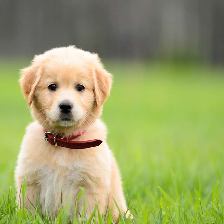

(1, 224, 224, 3)


In [123]:
# check that things look reasonable

test_img_path = 'data/misc/puppy.jpg'
img, x = get_image(test_img_path)

display(img)
print(x.shape)

In [124]:
# look at model's top 5 predictions for a sample image

predictions = vgg.predict(x)
predictions_decoded = decode_predictions(predictions)[0]

for p in predictions_decoded:
    print("{} (probability = {:0.3f})".format(p[1], p[2]))

golden_retriever (probability = 0.753)
Labrador_retriever (probability = 0.173)
soccer_ball (probability = 0.010)
kuvasz (probability = 0.004)
Norfolk_terrier (probability = 0.004)


---

#### 3. Convnet from scratch

Before transfer learning, let's build a convnet from scratch on our dataset for a baseline.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a dropout after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

In [108]:
# helpers

def get_all_imgs(category):
    return [
        os.path.join(dp, f) for dp, dn, filenames 
        in os.walk(category) for f in filenames 
        if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']
    ]

def prep_xy(data):
    x = np.array([d["x"] for d in data])
    y = [d["y"] for d in data]
    return x, y

In [95]:
# prep the data

root = 'data/not-pizza'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

# load all the images
data = []
for i, category in enumerate(categories):
    for img_path in get_all_imgs(category):
        _, x = get_image(img_path)
        data.append({ 'x': np.array(x[0]), 'y': i })

# count the number of classes
num_classes = len(categories)

# randomize data order
shuffle(data)

# create training / validation / test split (70%, 15%, 15%)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

# separate data for labels
x_train, y_train = prep_xy(train)
x_val, y_val = prep_xy(val)
x_test, y_test = prep_xy(test)

# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# sanity check
print("finished loading {} images from {} categories".format(len(data), num_classes))
print("train / validation / test split: {}, {}, {}".format(len(x_train), len(x_val), len(x_test)))
print("training data shape:", x_train.shape)
print("training labels shape:", y_train.shape)

finished loading 2000 images from 2 categories
train / validation / test split: 1400, 300, 300
training data shape: (1400, 224, 224, 3)
training labels shape: (1400, 2)


In [96]:
# construct network

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# use categorical cross-entropy loss function and adadelta optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

# check out model layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 32)        0         
__________

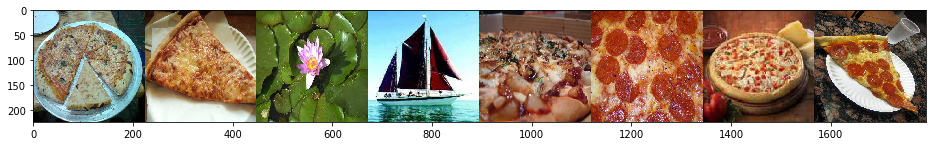

In [98]:
# preview a few imgs from our dataset

images = [img for cat in categories for img in get_all_imgs(cat)]
idx = [int(len(images) * random()) for _ in range(8)]
randos = [load_img(images[i], target_size=(224, 224)) for i in idx]

concat_image = np.concatenate([np.asarray(img) for img in randos], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [101]:
# train model for 50 epochs with batch size of 128 

history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val)
)

Train on 1400 samples, validate on 300 samples
Epoch 1/50
1400/1400 [==============================] - 5s - loss: 0.0400 - acc: 0.9886 - val_loss: 0.1386 - val_acc: 0.9467
Epoch 2/50
1400/1400 [==============================] - 5s - loss: 0.0368 - acc: 0.9879 - val_loss: 0.2443 - val_acc: 0.9200
Epoch 3/50
1400/1400 [==============================] - 5s - loss: 0.0791 - acc: 0.9657 - val_loss: 0.1570 - val_acc: 0.9400
Epoch 4/50
1400/1400 [==============================] - 5s - loss: 0.0332 - acc: 0.9900 - val_loss: 0.1443 - val_acc: 0.9433
Epoch 5/50
1400/1400 [==============================] - 5s - loss: 0.0302 - acc: 0.9893 - val_loss: 0.1459 - val_acc: 0.9433
Epoch 6/50
1400/1400 [==============================] - 5s - loss: 0.0231 - acc: 0.9943 - val_loss: 0.1546 - val_acc: 0.9400
Epoch 7/50
1400/1400 [==============================] - 5s - loss: 0.0213 - acc: 0.9957 - val_loss: 0.1593 - val_acc: 0.9400
Epoch 8/50
1400/1400 [==============================] - 5s - loss: 0.0291 - ac

In [111]:
# evaluate model on test set

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.313018095096
Test accuracy: 0.930000000795


---

#### 4. Transfer learning

In [112]:
# re-familiarize with vgg
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [113]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [114]:
# make all layers (except last) untrainable by freezing weights
for layer in model_new.layers[:-1]:
    layer.trainable = False

# ensure the last layer is trainable/not frozen
model_new.layers[-1].trainable = True

model_new.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [115]:
# train new model, with same hyperparameters (batch size and number of epochs) as before
# and same optimization algorithm.

history2 = model_new.fit(
    x_train,
    y_train, 
    batch_size=128, 
    epochs=50, 
    validation_data=(x_val, y_val)
)

Train on 1400 samples, validate on 300 samples
Epoch 1/50
1400/1400 [==============================] - 46s - loss: 0.6647 - acc: 0.6464 - val_loss: 0.5127 - val_acc: 0.8200
Epoch 2/50
1400/1400 [==============================] - 24s - loss: 0.4296 - acc: 0.8957 - val_loss: 0.3744 - val_acc: 0.8867
Epoch 3/50
1400/1400 [==============================] - 24s - loss: 0.3502 - acc: 0.9071 - val_loss: 0.3305 - val_acc: 0.8867
Epoch 4/50
1400/1400 [==============================] - 24s - loss: 0.2872 - acc: 0.9229 - val_loss: 0.2716 - val_acc: 0.9167
Epoch 5/50
1400/1400 [==============================] - 24s - loss: 0.2532 - acc: 0.9350 - val_loss: 0.2511 - val_acc: 0.9233
Epoch 6/50
1400/1400 [==============================] - 24s - loss: 0.2250 - acc: 0.9457 - val_loss: 0.2291 - val_acc: 0.9167
Epoch 7/50
1400/1400 [==============================] - 24s - loss: 0.2076 - acc: 0.9464 - val_loss: 0.2065 - val_acc: 0.9233
Epoch 8/50
1400/1400 [==============================] - 24s - loss: 0.1

In [116]:
# evaluate model on test set

loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.0660225081444
Test accuracy: 0.973333333333


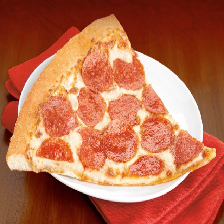

[[  5.35560162e-14   1.00000000e+00]]


In [145]:
# make predictions on some new images

img, x = get_image('data/misc/pizza2.jpg')

display(img)
print(model_new.predict(x))

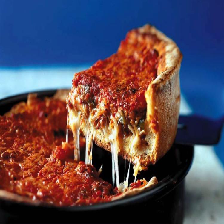

[[ 0.00154385  0.99845612]]


In [144]:
img, x = get_image('data/misc/pizza-chitown.jpg')

display(img)
print(model_new.predict(x))

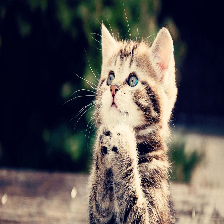

[[  1.00000000e+00   6.33919061e-17]]


In [147]:
img, x = get_image('data/misc/kitty.jpg')

display(img)
print(model_new.predict(x))